<a href="https://colab.research.google.com/github/ancantos99/g6_aprendizajeautomaticoico_s3/blob/main/colab/g6_aprendizajeautomaticoico_s3_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Parte 1: Preparación del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [2]:
#parte 2.- Cargar el Dataset
df = pd.read_csv("https://raw.githubusercontent.com/ancantos99/g6_aprendizajeautomaticoico_s3/refs/heads/main/dataset/dataset_procesado.csv")
print (df.head())
print(df.shape)

#NORMAILIZAR DATOS PARA CLUSTERING
columnas = ['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[columnas])

           TerminoBusqueda                    Match type  Impresiones  Clicks  \
0                  copilot                   Broad match         2060      47   
1  inteligencia artificial                   Broad match          694      20   
2              blackbox ai  Phrase match (close variant)          670      25   
3                  copilot                   Broad match          388       2   
4  inteligência artificial                   Broad match          312      23   

   CostoxClick            Keyword  TasaClicks  
0         0.10          coding ai    0.022816  
1         0.24        ai programs    0.028818  
2         0.20        ai software    0.037313  
3         0.31  AI software tools    0.005155  
4         0.31        ai programs    0.073718  
(14402, 7)


# **DBSCAN**

Agrupaciones densas de puntos sin necesidad de conocer cuantos cluster tienen.

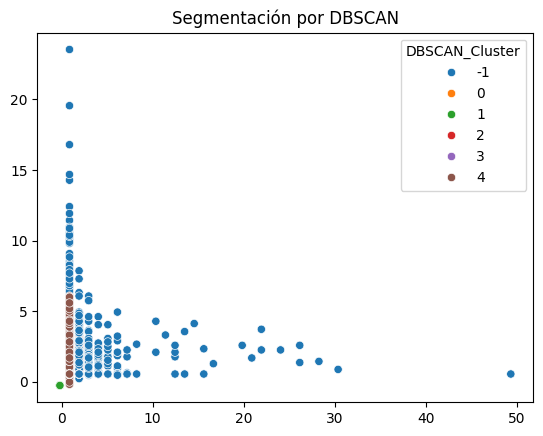

In [3]:
# IMPLEMENTACIÓN DE BDSCAN
# CON eps 0.6 y min_samples 10
dbscan = DBSCAN(eps=0.6, min_samples=10)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()

Entrenar el modelo

Con eps=0.8 y min_samples=15, el modelo DBSCAN generó clústeres más definidos y menos ruido, mejorando la agrupación de datos relevantes. Comparado con eps=0.6 y min_samples=10, el segundo entrenamiento ofrece mejor estabilidad y segmentación más precisa.

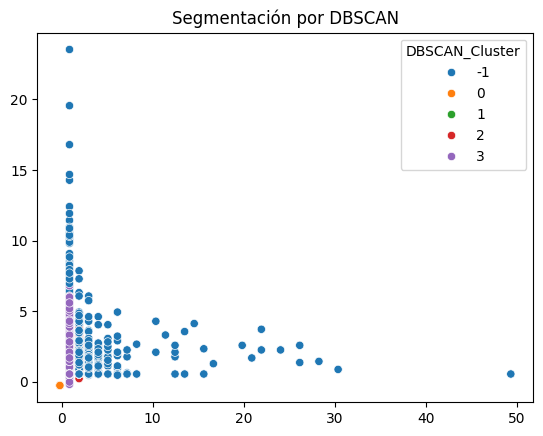

In [4]:
# IMPLEMENTACIÓN DE DBSCAN
# CON eps 0.8 y min_samples 15
dbscan = DBSCAN(eps=0.8, min_samples=15)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()

In [5]:
# Ver cuántos elementos hay en cada cluster
print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    12786
 1      649
 3      624
-1      241
 2      102
Name: count, dtype: int64


Muchos puntos están clasificados como -1 (ruido): Esto indica que una gran parte de los datos no fueron agrupados en ningún clúster, lo cual sugiere que el eps puede ser demasiado pequeño o min_samples demasiado alto.

Se han formado 4 clusters válidos (0, 1, 2, 3), pero con un gran predominio del ruido.

In [6]:
# Promedios por cluster
cluster_summary = df.groupby('DBSCAN_Cluster')[['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']].mean()
print(cluster_summary)


                Impresiones   Clicks  CostoxClick  TasaClicks
DBSCAN_Cluster                                               
-1                50.576763  4.33195     0.452656    0.445895
 0                 1.662834  0.00000     0.000000    0.000000
 1                 6.400616  1.00000     0.250755    0.289368
 2                11.343137  2.00000     0.213627    0.270499
 3                 1.000000  1.00000     0.280737    1.000000


- Cluster -1:  Grupo generalizado, alto volumen pero costo por clic elevado. Mucho tráfico pero eficiencia media.
- Cluster 0: Términos irrelevantes. No generan interacción.
- Cluster 1: Segmento aceptable. Genera clics con bajo costo
- Cluster 2: Buen rendimiento. Bajo costo y clics constantes
- Cluster 3: Segmento de alto rendimiento. CTR (tasa de clics) perfecta, ideal para priorizar.


**VISUALIZAR EN 2D LOS RESULTADOS DEL CLUSTERING USANDO PCA**





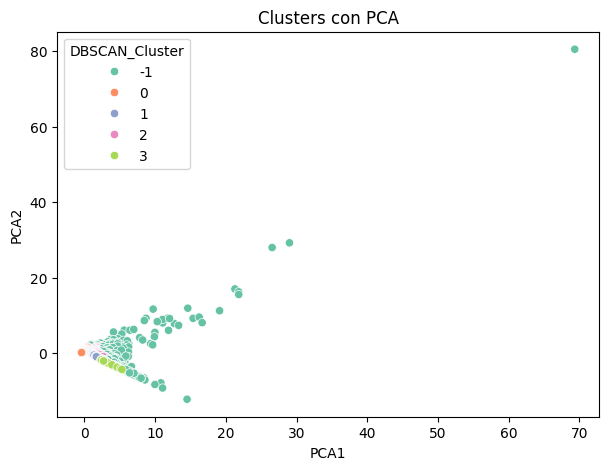

In [7]:
#Visualización 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Agregar al DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('Clusters con PCA')
plt.show()

**ELIMNAR EL CLUSTER 2**



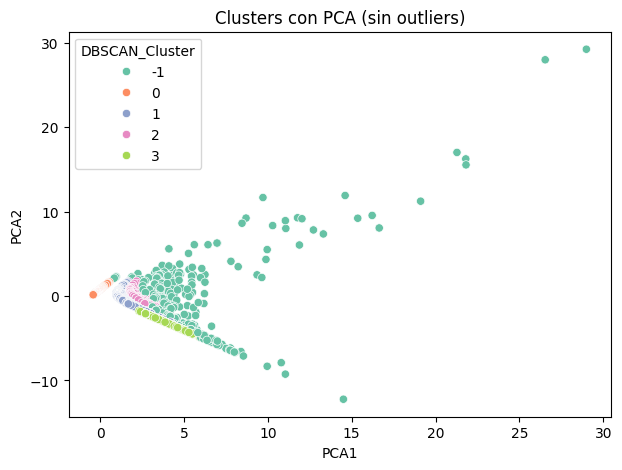

In [8]:
df_filtered = df[(df['PCA1'] < 40) &
                 (df['PCA2'] < 40)]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_filtered, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('Clusters con PCA (sin outliers)')
plt.show()

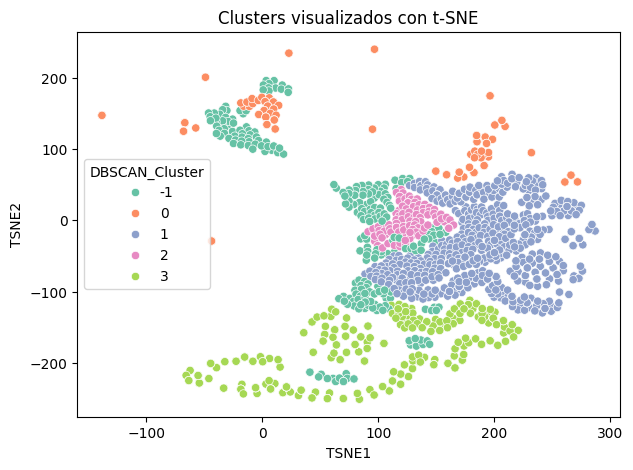

In [9]:
#Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

# Agregar al DataFrame
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

# Visualizar
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('Clusters visualizados con t-SNE')
plt.show()

In [10]:
#filtrar términos con al menos 10 impresiones para evitar sesgos
df_mostrarterminos = df[df['Impresiones'] >= 5]

# Mostrar los 5 mejores términos por cluster con mayor CTR
for c in sorted(df_mostrarterminos['DBSCAN_Cluster'].unique()):
    print(f"\nCluster {c} - Top 5 términos con mayor Tasa de Clicks:\n")
    display(df_mostrarterminos[df_mostrarterminos['DBSCAN_Cluster'] == c]
            .sort_values(by='TasaClicks', ascending=False)
            .loc[:, ['TerminoBusqueda', 'Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']]
            .head(5))


Cluster -1 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
695,ia que cria imagens de graça,7,5,0.38,0.714286
488,doctrina ai exam,9,6,0.09,0.666667
924,ai project maker,5,3,0.10,0.600000
1073,ia para apresentação de slides,5,3,0.25,0.600000
899,app de inteligência artificial gratuito,5,3,0.39,0.600000



Cluster 0 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
1081,ia offline,5,0,0.0,0.0
58,decohere ai,50,0,0.0,0.0
63,zzz code ai,47,0,0.0,0.0
66,gemini ai,46,0,0.0,0.0
70,haiper ai,45,0,0.0,0.0



Cluster 1 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
1078,free app builder without coding,5,1,0.33,0.2
1076,genmo ai,5,1,0.10,0.2
1075,inteligencia artificial imagenes,5,1,0.10,0.2
996,kite ia,5,1,0.56,0.2
993,montar slides com ia,5,1,0.33,0.2



Cluster 2 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
888,criador de apresentações ia,5,2,0.41,0.4
1057,expand ai,5,2,0.10,0.4
1025,javascript ia,5,2,0.30,0.4
1021,ia para fazer slide,5,2,0.38,0.4
1020,inteligencia artificial gratis,5,2,0.29,0.4
